#### ANOMALY DETECTION

### Using Parametric Models

parametric models asssumes that the majority of the data points are governed by some well known probability distribution

In [100]:
import pandas as pd 

In [101]:
stocks=pd.read_csv('stocks.csv', header='infer')

In [102]:
stocks.head(3)

,Date,MSFT,F,BAC
0,01/03/2007,29.860001,7.51,53.330002
1,01/04/2007,29.809999,7.70,53.669998
2,01/05/2007,29.639999,7.62,53.240002


In [103]:
# stocks.info() 

In [104]:
stocks.index=stocks['Date']
stocks.head(3)

,Date,MSFT,F,BAC
Date,,,,
01/03/2007,01/03/2007,29.860001,7.51,53.330002
01/04/2007,01/04/2007,29.809999,7.70,53.669998
01/05/2007,01/05/2007,29.639999,7.62,53.240002


In [105]:
stocks = stocks.drop(['Date'], axis=1)
stocks.head(3)

,MSFT,F,BAC
Date,,,
01/03/2007,29.860001,7.51,53.330002
01/04/2007,29.809999,7.70,53.669998
01/05/2007,29.639999,7.62,53.240002


To calculate the % change
We use

$ \delta(t) = 10*(x_t-x_(t-1))/x_(t-1)$

In [106]:
import numpy as np

In [108]:
N, d = stocks.shape

In [109]:
N

2518

In [110]:
d

3

In [111]:
delta= pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values - stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values), columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head(3)

,MSFT,F,BAC
Date,,,
01/04/2007,-0.167455,2.529960,0.637532
01/05/2007,-0.570278,-1.038961,-0.801185
01/08/2007,0.978411,1.443570,0.394438


In [112]:
# stocks.head(3)

In [17]:
(29.809999-29.860001)/29.860001

-0.0016745478340740583

In [113]:
# Plot the values in 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

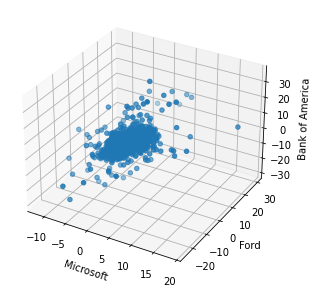

In [114]:
fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig.scatter(delta.MSFT, delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

Assume the data follows a multivariate Gaussian distribution. so we compute the mean covariance matrix of the 3-Dimensional data.

In [115]:
meanValue = delta.mean()
meanValue

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64

In [116]:
covValue = delta.cov()
covValue

,MSFT,F,BAC
MSFT,3.191674,2.136351,2.788870
F,2.136351,8.524944,4.997405
BAC,2.788870,4.997405,13.770761


We theN use the distance measure to determine the anomolous trading days.
The formula is : $Mahalanobis(x) = (x-\bar{x})\sum^{-1}(x-\bar{x})^{T}$

In [117]:
from numpy.linalg import inv

In [118]:
X = delta.to_numpy()
X

array([[-0.16745478,  2.52996005,  0.63753232],
       [-0.57027845, -1.03896104, -0.80118505],
       [ 0.97841096,  1.44356955,  0.39443838],
       ...,
       [-0.45827592, -1.1299435 , -1.23839446],
       [-0.14287982, -0.16326531, -1.47783251],
       [-1.20827182, -0.81766149,  0.45454545]])

In [119]:
S = covValue.to_numpy()
S

array([[ 3.19167433,  2.1363511 ,  2.78886962],
       [ 2.1363511 ,  8.52494366,  4.99740498],
       [ 2.78886962,  4.99740498, 13.7707607 ]])

In [120]:
type(S)

numpy.ndarray

In [121]:
for i in range(3):
    X[:,i]=X[:,i]-meanValue[i]

In [122]:
def mahalanobis(row):
    return np.matmul(row, S).dot(row)

In [123]:
anomaly_score = np.apply_along_axis(mahalanobis, axis=1, arr=X)
anomaly_score

array([69.07129591, 36.05502792, 33.24355484, ..., 56.45369823,
       37.14774392, 12.10566607])

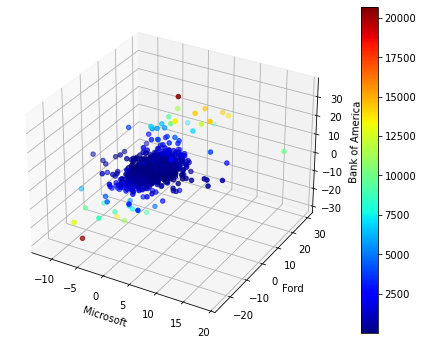

In [124]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111,projection='3d')
p=ax.scatter(delta.MSFT, delta.F,delta.BAC, c= anomaly_score, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

In [149]:
anom =pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly Score'])
anom.head(3)

,Anomaly Score
Date,
01/04/2007,0.402543
01/05/2007,0.225723
01/08/2007,0.252133


In [150]:
# concatenate the delta with anom
result = pd.concat((delta, anom), axis=1)
result.tail(3)

,MSFT,F,BAC,Anomaly Score
Date,,,,
12/28/2016,-0.503279,-1.191318,-1.271745,0.266030
12/29/2016,-0.187883,-0.224639,-1.511183,0.267501
12/30/2016,-1.253275,-0.879036,0.421195,0.293086


In [127]:
result.nlargest(2,'Anomaly Score')

,MSFT,F,BAC,Anomaly Score
Date,,,,
04/09/2009,2.456295,7.280398,35.235771,20691.465032
10/07/2008,-6.789282,-20.928583,-26.259300,20471.095209


Text(0, 0.5, 'Percent Change')

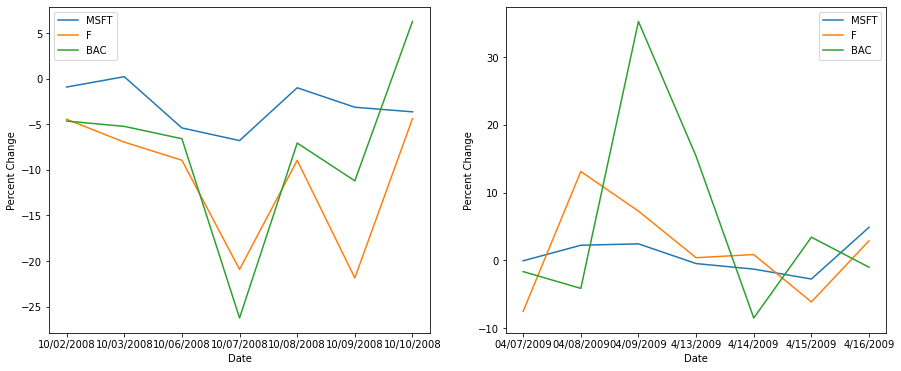

In [128]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize=(15,6))
ts=delta[440:447]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts=delta[568:575]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

### USING THE DISTANCE BASED APPROACH

- Distance based approach is a model free anomaly detection approach
- does not require one to construct an explicit model of the normal class to dtermine the anomaly score of the data.
- Using K-Nearest Neighbor approach to calculate the anomaly score
- The Normal distance is the shortest distance to the kth nearest neighbour and the Anomaly has the largest distance to the kth.
- using k = 4

In [130]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance 

In [131]:
knn =4

In [133]:
nbrs=NearestNeighbors(n_neighbors= knn, metric=distance.euclidean).fit(delta.to_numpy())

# metric function that measures euclidean distance

In [134]:
distance, indices = nbrs.kneighbors(delta.to_numpy())

In [140]:
anomaly_score = distance[:,knn-1]
anomaly_score

array([0.40254328, 0.22572317, 0.25213262, ..., 0.26603012, 0.26750148,
       0.29308581])

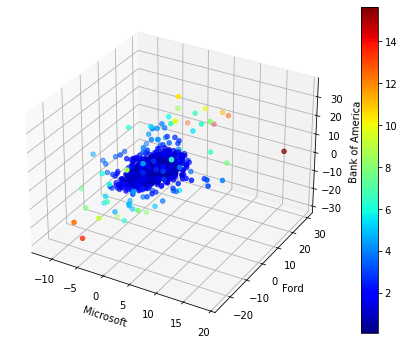

In [141]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111,projection='3d')
p=ax.scatter(delta.MSFT, delta.F,delta.BAC, c= anomaly_score, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

In [144]:
# flag off top 5 highest anomaly scores
anom=pd.DataFrame(anomaly_score, index = delta.index, columns =['Anomaly Score'])

In [153]:
anom.head(5)

,Anomaly Score
Date,
01/04/2007,0.402543
01/05/2007,0.225723
01/08/2007,0.252133
01/09/2007,0.175053
01/10/2007,0.284450


In [155]:
result = pd.concat((delta, anom), axis =1)

In [157]:
# result.head()

In [158]:
result.nlargest(5, 'Anomaly Score')

,MSFT,F,BAC,Anomaly Score
Date,,,,
10/13/2008,18.559648,20.039128,9.166457,15.642827
11/26/2008,2.456248,29.456698,4.223406,14.212749
10/07/2008,-6.789282,-20.928583,-26.259300,13.751302
11/28/2008,-1.362724,25.054905,5.280972,13.139586
9/30/2008,6.672314,24.638866,15.669129,12.599739


Text(0, 0.5, 'Percent Change')

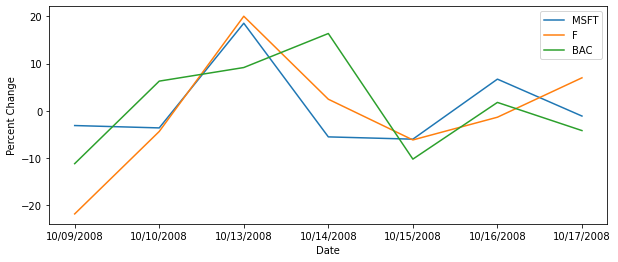

In [161]:
fig = plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ts=delta[445:452]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

# ts=delta[568:575]
# ts.plot.line(ax=ax2)
# ax2.set_xticks(range(7))
# ax2.set_xticklabels(ts.index)
# ax2.set_ylabel('Percent Change')